<a href="https://colab.research.google.com/github/eejd/course-content/blob/2021-bayes/tutorials/W2D1_BayesianStatistics/W2D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 1, Tutorial 1
# Bayes with a binary hidden state

__Content creators:__ [insert your name here]

__Content reviewers:__ 

# Tutorial Objectives
This is the first in a series of two core tutorials on Bayesian statistics. In these tutorials, we will explore the fundemental concepts of the Bayesian approach from two perspectives. This tutorial will work through an example of Bayesian inference and decision making using a binary hidden state. The second main tutorial extends these concepts to a continuous hidden state. In the next days, each of these basic ideas will be extended--first through time as we consider what happens when we infere a hidden state using multiple observations and when the hidden state changes across time. In the third day, we will introduce the notion of how to use inference and decisions to select actions for optimal control. For this tutorial, you will be introduced to our binary state fishing problem!

This notebook will introduce the fundamental building blocks for Bayesian statistics: 

1. How do we use probability distributions to represent hidden states?
2. How does marginalization work and how can we use it?
3. How do we combine new information with our prior knowledge?
4. How do we combine the possible loss (or gain) for making a decision with our probabilitic knowledge?


In [1]:
#@title Video 1: Introduction to Bayesian Statistics
from IPython.display import YouTubeVideo
# video = YouTubeVideo(id='K4sSKZtk-Sc', width=854, height=480, fs=1)
# print("Video available at https://youtube.com/watch?v=" + video.id)

## Setup  
Please execute the cells below to initialize the notebook environment.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import transforms
from matplotlib import gridspec
from scipy.optimize import fsolve

from collections import namedtuple

In [3]:
#@title Figure Settings
import ipywidgets as widgets       # interactive display
from ipywidgets import GridspecLayout
from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
# @title Helper Functions
def compute_marginal(px, py, cor):
    # calculate 2x2 joint probabilities given marginals p(x=1), p(y=1) and correlation
    p11 = px*py + cor*np.sqrt(px*py*(1-px)*(1-py))
    p01 = px - p11
    p10 = py - p11
    p00 = 1.0 - p11 - p01 - p10
    return np.asarray([[p00, p01], [p10, p11]])
# test
# print(compute_marginal(0.4, 0.6, -0.8))

def compute_cor_range(px,py):
    # Calculate the allowed range of correlation values given marginals p(x=1) and p(y=1)
    def p11(corr):
        return px*py + corr*np.sqrt(px*py*(1-px)*(1-py))
    def p01(corr):
        return px - p11(corr)
    def p10(corr):
        return py - p11(corr)
    def p00(corr):
        return 1.0 - p11(corr) - p01(corr) - p10(corr)
    Cmax = min(fsolve(p01, 0.0), fsolve(p10, 0.0))
    Cmin = max(fsolve(p11, 0.0), fsolve(p00, 0.0))
    return Cmin, Cmax

def plot_joint_probs(P, ):
    assert np.all(P >= 0), "probabilities should be >= 0"
    # normalize if not
    P = P / np.sum(P)
    marginal_y = np.sum(P,axis=1)
    marginal_x = np.sum(P,axis=0)

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    # start with a square Figure
    fig = plt.figure(figsize=(5, 5))

    joint_prob = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    rect_x_cmap = plt.cm.Blues
    rect_y_cmap = plt.cm.Reds

    # Show joint probs and marginals
    ax = fig.add_axes(joint_prob)
    ax_x = fig.add_axes(rect_histx, sharex=ax)
    ax_y = fig.add_axes(rect_histy, sharey=ax)

    # Show joint probs and marginals
    ax.matshow(P,vmin=0., vmax=1., cmap='Greys')
    ax_x.bar(0, marginal_x[0], facecolor=rect_x_cmap(marginal_x[0]))
    ax_x.bar(1, marginal_x[1], facecolor=rect_x_cmap(marginal_x[1]))
    ax_y.barh(0, marginal_y[0], facecolor=rect_y_cmap(marginal_y[0]))
    ax_y.barh(1, marginal_y[1], facecolor=rect_y_cmap(marginal_y[1]))
    # set limits
    ax_x.set_ylim([0,1])
    ax_y.set_xlim([0,1])

    # show values 
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{P[i,j]:.2f}"
        ax.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = marginal_x[i]
        c = f"{v:.2f}"
        ax_x.text(i, v +0.1, c, va='center', ha='center', color='black')
        v = marginal_y[i]
        c = f"{v:.2f}"
        ax_y.text(v+0.2, i, c, va='center', ha='center', color='black')

    # set up labels
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['R','B'])
    ax.set_yticklabels(['0','1'])
    ax.set_xlabel('color')
    ax.set_ylabel('size')
    ax_x.axis('off')   
    ax_y.axis('off')   
    return fig
# test
# P = np.random.rand(2,2)
# P = np.asarray([[0.9, 0.8], [0.4, 0.1]])
# P = P / np.sum(P)
# fig = plot_joint_probs(P)
# plt.show(fig)
# plt.close(fig)


# fig = plot_prior_likelihood(0.5, 0.3)
# plt.show(fig)
# plt.close(fig)
def plot_prior_likelihood_posterior(prior, likelihood, posterior):

    # definitions for the axes
    left, width = 0.05, 0.16
    bottom, height = 0.05, 0.9
    padding = 0.06
    small_width = 0.1
    left_space = left + small_width + padding
    added_space = padding + width

    fig = plt.figure(figsize=(17, 3))

    rect_prior = [left, bottom, small_width, height]
    rect_utility = [left_space , bottom , width, height]
    rect_expected = [left_space +  added_space, bottom , width, height]

    ax_prior = fig.add_axes(rect_prior)
    ax_likelihood = fig.add_axes(rect_utility, sharey=ax_prior)
    ax_posterior = fig.add_axes(rect_expected, sharey = ax_prior)

    rect_colormap = plt.cm.Blues

    # Show posterior probs and marginals
    ax_prior.barh(0, prior[0], facecolor = rect_colormap(prior[0, 0]))
    ax_prior.barh(1, prior[1], facecolor = rect_colormap(prior[1, 0]))
    ax_likelihood.matshow(likelihood, vmin=0., vmax=1., cmap='Reds')
    ax_posterior.matshow(posterior, vmin=0., vmax=1., cmap='Greens')


    # Probabilities plot details
    ax_prior.set(xlim = [1, 0], yticks = [0, 1], yticklabels = ['left', 'right'],
                 ylabel = 'state (s)', title = "Prior p(s)")
    ax_prior.axis('off')

    # Likelihood plot details
    ax_likelihood.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'], 
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)', 
                   title = 'Likelihood p(m | s)')
    ax_likelihood.xaxis.set_ticks_position('bottom')
    ax_likelihood.spines['left'].set_visible(False)
    ax_likelihood.spines['bottom'].set_visible(False)

    # Posterior plot details

    ax_posterior.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'], 
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)', 
                   title = 'Posterior p(s | m)')
    ax_posterior.xaxis.set_ticks_position('bottom')
    ax_posterior.spines['left'].set_visible(False)
    ax_posterior.spines['bottom'].set_visible(False)


    # show values 
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{posterior[i,j]:.2f}"
        ax_posterior.text(j,i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{likelihood[i,j]:.2f}"
        ax_likelihood.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i, 0]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')

def plot_prior_likelihood(ps, p_a_s1, p_a_s0):
    likelihood = np.asarray([[p_a_s1, 1-p_a_s1],[p_a_s0, 1-p_a_s0]])
    assert 0.0 <= ps <= 1.0
    prior = np.asarray([ps, 1 - ps])
    posterior = likelihood * prior.reshape((2, 1))
    posterior /= np.sum(posterior, axis = 0)

    # definitions for the axes
    left, width = 0.05, 0.16
    bottom, height = 0.05, 0.9
    padding = 0.06
    small_width = 0.1
    left_space = left + small_width + padding
    added_space = padding + width

    fig = plt.figure(figsize=(17, 3))

    rect_prior = [left, bottom, small_width, height]
    rect_utility = [left_space , bottom , width, height]
    rect_expected = [left_space +  added_space, bottom , width, height]

    ax_prior = fig.add_axes(rect_prior)
    ax_likelihood = fig.add_axes(rect_utility, sharey=ax_prior)
    ax_posterior = fig.add_axes(rect_expected, sharey = ax_prior)

    rect_colormap = plt.cm.Blues

    # Show posterior probs and marginals
    ax_prior.barh(0, prior[0], facecolor = rect_colormap(prior[0]))
    ax_prior.barh(1, prior[1], facecolor = rect_colormap(prior[1]))
    ax_likelihood.matshow(likelihood, vmin=0., vmax=1., cmap='Reds')
    ax_posterior.matshow(posterior, vmin=0., vmax=1., cmap='Greens')


    # Probabilities plot details
    ax_prior.set(xlim = [1, 0], yticks = [0, 1], yticklabels = ['left', 'right'],
                 ylabel = 'state (s)', title = "Prior p(s)")
    ax_prior.axis('off')

    # Likelihood plot details
    ax_likelihood.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'], 
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)', 
                   title = 'Likelihood p(m | s)')
    ax_likelihood.xaxis.set_ticks_position('bottom')
    ax_likelihood.spines['left'].set_visible(False)
    ax_likelihood.spines['bottom'].set_visible(False)

    # Posterior plot details

    ax_posterior.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'], 
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)', 
                   title = 'Posterior p(s | m)')
    ax_posterior.xaxis.set_ticks_position('bottom')
    ax_posterior.spines['left'].set_visible(False)
    ax_posterior.spines['bottom'].set_visible(False)


    # show values 
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{posterior[i,j]:.2f}"
        ax_posterior.text(j,i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{likelihood[i,j]:.2f}"
        ax_likelihood.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')
    return fig




# fig = plot_prior_likelihood(0.5, 0.3)
# plt.show(fig)
# plt.close(fig)

from matplotlib import colors
def plot_utility(ps):
    prior = np.asarray([ps, 1 - ps])

    utility = np.array([[2, -3], [-2, 1]])

    expected = prior @ utility 

    # definitions for the axes
    left, width = 0.05, 0.16
    bottom, height = 0.05, 0.9
    padding = 0.04
    small_width = 0.1
    left_space = left + small_width + padding
    added_space = padding + width

    fig = plt.figure(figsize=(17, 3))

    rect_prior = [left, bottom, small_width, height]
    rect_utility = [left + added_space , bottom , width, height]
    rect_expected = [left + 2* added_space, bottom , width, height]

    ax_prior = fig.add_axes(rect_prior)
    ax_utility = fig.add_axes(rect_utility, sharey=ax_prior)
    ax_expected = fig.add_axes(rect_expected)

    rect_colormap = plt.cm.Blues

    # Data of plots
    ax_prior.barh(0, prior[0], facecolor = rect_colormap(prior[0]))
    ax_prior.barh(1, prior[1], facecolor = rect_colormap(prior[1]))
    ax_utility.matshow(utility, cmap='cool')
    norm = colors.Normalize(vmin=-3, vmax=3)
    ax_expected.bar(0, expected[0], facecolor = rect_colormap(norm(expected[0])))
    ax_expected.bar(1, expected[1], facecolor = rect_colormap(norm(expected[1])))

    # Probabilities plot details
    ax_prior.set(xlim = [1, 0], yticks = [0, 1], yticklabels = ['left', 'right'],
                 ylabel = 'state (s)', title = "Probability of state")
    ax_prior.axis('off')

    # Utility plot details
    ax_utility.set(xticks = [0, 1], xticklabels = ['left', 'right'], 
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'action (a)', 
                   title = 'Utility')
    ax_utility.xaxis.set_ticks_position('bottom')
    ax_utility.spines['left'].set_visible(False)
    ax_utility.spines['bottom'].set_visible(False)

    # Expected utility plot details
    ax_expected.set(title = 'Expected utility', ylim = [-3, 3],
                    xticks = [0, 1], xticklabels = ['left', 'right'],
                    xlabel = 'action (a)',
                    yticks = [])
    ax_expected.xaxis.set_ticks_position('bottom')
    ax_expected.spines['left'].set_visible(False)
    ax_expected.spines['bottom'].set_visible(False)

    # show values 
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)

    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{utility[i,j]:.2f}"
        ax_utility.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i in ind:
        v = expected[i]
        c = f"{v:.2f}"
        ax_expected.text(i, 2.5, c, va='center', ha='center', color='black')

    return fig

def plot_prior_likelihood_utility(ps, p_a_s1, p_a_s0):
    likelihood = np.asarray([[p_a_s1, 1-p_a_s1],[p_a_s0, 1-p_a_s0]])
    assert 0.0 <= ps <= 1.0
    assert 0.0 <= p_a_s1 <= 1.0
    assert 0.0 <= p_a_s0 <= 1.0
    prior = np.asarray([ps, 1 - ps])

    utility = np.array([[2, -3], [-2, 1]])
    posterior = likelihood * prior.reshape((2, 1))
    posterior /= np.sum(posterior, axis = 0)

    expected = np.multiply(utility, posterior)

    # definitions for the axes
    left, width = 0.05, 0.16
    bottom, height = 0.05, 0.9
    padding = 0.05
    small_width = 0.1
    left_space = left + small_width + padding
    added_space = padding + width

    fig = plt.figure(figsize=(17, 3))

    rect_prior = [left, bottom, small_width, height]
    rect_likelihood = [left_space, bottom , width, height]
    rect_posterior = [left_space + added_space, bottom , width, height]
    rect_utility = [left_space + 2*added_space, bottom , width, height]
    rect_expected = [left_space + 3*added_space, bottom , width, height]

    ax_likelihood = fig.add_axes(rect_likelihood)
    ax_prior = fig.add_axes(rect_prior, sharey=ax_likelihood)
    ax_posterior = fig.add_axes(rect_posterior, sharey=ax_likelihood)
    ax_utility = fig.add_axes(rect_utility, sharey=ax_posterior)
    ax_expected = fig.add_axes(rect_expected, sharey=ax_utility)


    rect_colormap = plt.cm.Blues

    # Show posterior probs and marginals
    ax_prior.barh(0, prior[0], facecolor = rect_colormap(prior[0]))
    ax_prior.barh(1, prior[1], facecolor = rect_colormap(prior[1]))
    ax_likelihood.matshow(likelihood, vmin=0., vmax=1., cmap='Reds')
    ax_posterior.matshow(posterior, vmin=0., vmax=1., cmap='Greens')
    ax_utility.matshow(utility, vmin=0., vmax=1., cmap='cool')
    ax_expected.matshow(expected, vmin=0., vmax=1., cmap='Wistia')


    # Probabilities plot details
    ax_prior.set(xlim = [1, 0], yticks = [0, 1], yticklabels = ['left', 'right'],
                 ylabel = 'state (s)', title = "Prior p(s)")
    ax_prior.axis('off')

    # Likelihood plot details
    ax_likelihood.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'], 
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)', 
                   title = 'Likelihood p(m | s)')
    ax_likelihood.xaxis.set_ticks_position('bottom')
    ax_likelihood.spines['left'].set_visible(False)
    ax_likelihood.spines['bottom'].set_visible(False)

    # Posterior plot details

    ax_posterior.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'], 
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)', 
                   title = 'Posterior p(s | m)')
    ax_posterior.xaxis.set_ticks_position('bottom')
    ax_posterior.spines['left'].set_visible(False)
    ax_posterior.spines['bottom'].set_visible(False)

    # Utility plot details
    ax_utility.set(xticks = [0, 1], xticklabels = ['left', 'right'], 
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'action (a)', 
                   title = 'Utility')
    ax_utility.xaxis.set_ticks_position('bottom')
    ax_utility.spines['left'].set_visible(False)
    ax_utility.spines['bottom'].set_visible(False)

    # Utility plot details
    ax_expected.set(xticks = [0, 1], xticklabels = ['left', 'right'], 
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'action (a)', 
                   title = 'Expected utility')
    ax_expected.xaxis.set_ticks_position('bottom')
    ax_expected.spines['left'].set_visible(False)
    ax_expected.spines['bottom'].set_visible(False)

    # show values 
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{posterior[i,j]:.2f}"
        ax_posterior.text(j,i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{likelihood[i,j]:.2f}"
        ax_likelihood.text(j,i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{utility[i,j]:.2f}"
        ax_utility.text(j,i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{expected[i,j]:.2f}"
        ax_expected.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')


    # # show values 
    # ind = np.arange(2)
    # x,y = np.meshgrid(ind,ind)
    # for i,j in zip(x.flatten(), y.flatten()):
    #     c = f"{P[i,j]:.2f}"
    #     ax.text(j,i, c, va='center', ha='center', color='white')
    # for i in ind:
    #     v = marginal_x[i]
    #     c = f"{v:.2f}"
    #     ax_x.text(i, v +0.2, c, va='center', ha='center', color='black')
    #     v = marginal_y[i]
    #     c = f"{v:.2f}"
    #     ax_y.text(v+0.2, i, c, va='center', ha='center', color='black')

    return fig


# Section 1: Gone Fishin' Problem


In [5]:
#@title Video 2: Gone Fishin'
from IPython.display import YouTubeVideo
# video = YouTubeVideo(id='K4sSKZtk-Sc', width=854, height=480, fs=1)
# print("Video available at https://youtube.com/watch?v=" + video.id)

## Binary hidden states - where are the fish?

You were just introduced to the binary hidden state problem we are going to explore. You need to decide which side to fish on. We know fish like to school together. On different days the school of fish is either on the left or right side, but we don’t know what the case is today. We will represent our knowledge probabilistically, asking how to make a decision (where to decide the fish are or where to fish) and what to expect in terms of gains or losses. In the next two sections we will consider just the probability of where the fish might be and what you gain or lose by choosing where to fish.

Remember, you can either think of your self as a scientist conducting an experiment or as a brain trying to make a decision. The Bayesian approach is the same!


# Section 2: Deciding where to fish 



## Video 3: Utility 

Let's assume you know something about the probability that the school of fish is on the left side of the dock today. Of course, you then also know something about the probability that it is on the right side ($P(L) = 1 - P(R)$). We'll circle back to how you know this (and how you can improve the accuracy of your knowledge) later.

So, you need to decide what action to take - whether you will fish on the left side or the right side. It may seem obvious - you could just fish on the side where the probability of the fish being is higher!

Unfortunately, decisions and actions are always a little more complicated. Deciding to fish may be influenced by more than just the probability of the school of fish being there. In our example, fish are much easier to catch on the left side of the dock, as there are no submarines. You also know that you will get sunburnt if you fish on whichever side, if the shool of fish is not there!

We quantify these kinds of factors numerically using a function we call **utility**. Utility describes the consequences of your actions: how much value you gain (or if negative, lose) given the state of the world ($s$) and the action you take ($a$). In this case, the state of the world is where the school of fish is located: the left side ($s$ = left) or the right side ($s$ = right). The action is where you fish: the left side ($a$ = left) or the right side ($a$ = right).

Let's come up with a numerical description of our utility for all possible combinations of state and action:

| Utility: U(s,a)   | a = left   | a = right  |
| ----------------- |----------|----------|
| s = Left          | 2          | -3         |
| s = right         | -2         |  1         |


Because fish are easier to catch on the left side, the utility of fishing on the left side and the school being located on the left side ($U( s = left, a = left) = 2$) is higher than the utility of fishing on the right side and the school being located on the right side ($U( s = right, a = right)$ = 1). The values are negative when you are fishing on the opposite side of where the fish are because you'll get sunburnt and not be very succesful fishing so you will have negative utility (a loss).

Now we have a bunch of numbers but how do we decide what to do? We need a guess of the utility of each action - we would then take the action that we expect to have the highest utility, or gain, for us. To determine this, we need to calculate the **expected utility** of that action by taking our utility matrix and weighting it by our guessed probabilities. Our expected utility for fishing on the left side is the utility of that action and state = left multiplied by the probability of the state = left, plus the utility of that action and state = right multiplied by the probability of the state = right: $U(s = left,a = left)p(s = left) + U(s = right,a = left)p(s = right)$.

We can formalize this as:

$$\text{Expected utility of action a} = \sum_{s}U(s,a)p(s) $$

In other words, the expected utility of an action a is the sum over possible states of the utility of that action and state times the probability of that state.

You can then take the action that has the highest expected utility!

## Interactive Demo 2: Exploring the decision

Let's start to get a sense of how all this works. 

Take a look at the interactive demo below. You can change the probability that the school of fish is on the left side ($p(s = left)$ using the slider. This also specifies the probability that the school is on the right as these two probabilities have to add up to one.  You will see the corresponding expected utility of each action.

First, make sure you understand how the expected utility of each action is being computed from the probabilities and the utility values. In the initial state: the probability of the fish being on the left is 0.9 and on the right is 0.1. The expected utility of the action of fishing on the left is then $U(s = left,a = left)p(s = left) + U(s = right,a = left)p(s = right) = 2(0.9) + -2(0.1) = 1.6$.

For each of these scenarios, think and discuss first. Then use the demo to try out each and see if your action would have been correct (that is, if the expected value of that action is the highest).


1.  You just arrived at the dock for the first time and have no sense of where the fish might be. So you guess that the probability of the school being on the left side is 0.5 (so the probability on the right side is also 0.5). Which side would you choose to fish on given our utility values?
2.  You think that the probability of the school being on the left side is very low (0.1) and correspondingly high on the right side (0.9). Which side would you choose to fish on given our utility values?
3.  What would you choose if the probability of the school being on the left side is slightly lower than on the right side (0. 4 vs 0.6)?

In [6]:
# @markdown Execute this cell to use the widget
ps_widget = widgets.FloatSlider(0.9, description='p(s = left)', min=0.0, max=1.0, step=0.01)

@widgets.interact(
    ps = ps_widget,
)
def make_utility_plot(ps):
    fig = plot_utility(ps)
    plt.show(fig)
    plt.close(fig)
    return None


interactive(children=(FloatSlider(value=0.9, description='p(s = left)', max=1.0, step=0.01), Output()), _dom_c…

In [7]:
# to_remove explanation

# 1)  With equal probabilities, the expected utility is higher on the left side, 
#    since that is the side without submarines, so you would choose to fish there.


# 2)  If the probability that the fish is on the right side is high, you would
#     choose to fish there. The high probability of fish being on the right far outweights
#    the slightly higher utilities from fishing on the left (as you are unlikely to gain these)

# 3)  If the probability that the fish is on the right side is just slightly higher 
#.    than on the left, you would choose the left side as the expected utility is still 
#.    higher on the left. Note that in this situation, you are not simply choosing the
#.    side with the higher probability - the utility really matters here for the decision

In this section, you have seen that both the utility of various state and action pairs and our knowledge of the probability of each state affects your decision. Importantly, we want our knowledge of the probability of each state to be as accurate as possible! 

So how do we know these probabilities? We may have prior knowledge from years of fishing at the same dock. Over those years, we may have learned that the fish are more likely to be on the left side for example. We want to make sure this knowledge is as accurate as possible though. To do this, we want to collect more data, or take some more measurements! For the next few sections, we will focus on making our knowledge of the probability as accurate as possible, before coming back to using utility to make decisions.

# Section 3: Likelihood of the fish being on either side
 


## Video 3: Likelihood 

First, we'll think about what it means to take a measurement (also often called an observation or just data) and what it tells you about the probability of the hidden state we are interested in.

  We will watch someone fish (for let's say 10 minutes) and our measurement is whether they catch a fish or not. We know something about what catching a fish means for the likelihood of the fish being on one side or the other. In the river in the video, we knew that the chance of catching a fish given they fish on the same side as the school was 50%. Otherwise, it was 10%.

## Think! 2: Guessing the location of the fish

Let's say we go to different dock from the one in the video. Here, there are different probabilities of catching fish given the state of the world. In this case, if they fish on the side of the dock where the fish are, they have a 70% chance of catching a fish. Otherwise, they catch a fish with only 20% probability. The fisherman is fishing on the left side. 

1) Figure out each of the following:
- probability of catching a fish given that the school of fish is on the left side, $p(m = catch\text{ } fish | s = left )$
- probability of not catching a fish given that the school of fish is on the left side, $p(m = no \text{ } fish | s = left)$
- probability of catching a fish given that the school of fish is on the right side, $p(m = catch  \text{ } fish | s = right)$
- probability of not catching a fish given that the school of fish is on the right side, $p(m = no \text{ } fish | s = right)$

2) If the fisherman catches a fish, which side would you guess the school is on? Why?

3) If the fisherman does not catch a fish, which side would you guess the school is on? Why?


In [8]:
#to_remove explanation

# 1) The fisherman is on the left side so:
#       - p(m = catch fish | s = left) = 0.7 because they have a 70% chance of catching
#         a fish when on the same side as the school
#       - p(m = no fish | s = left) = 0.3 because the probability of catching a fish 
#         and not catching a fish for a given state must add up to 1 as these
#         are the only options: 1 - 0.7 = 0.3
#       - p(m = catch fish | s = right) = 0.2
#       - p(m = no fish | s = right) = 0.8

# 2) If the fisherman catches a fish, you would guess the school of fish is on the
#     left side. This is because the probability of catching a fish given that the 
#    school is on the left side (0.7) is higher than the probability given that 
#    the school is on the right side (0.2).   
  
# 3) If the fisherman does not catch a fish, you would guess the school of fish is on the
#     right side. This is because the probability of not catching a fish given that the 
#    school is on the right side (0.8) is higher than the probability given that 
#    the school is on the right side (0.3).   
  

In the prior exercise, you guessed where the school of fish was based on the measurement you took (watching someone fish). You did this by choosing the state (side of school) that maximized the probability of the measurement. In other words, you estimated the state by maximizing the likelihood. This is called maximum likelihood estimation (MLE) and you've encountered it before during this course, in W1D3!

What if you had been going to this river for years and you knew that the fish were almost always on the left side? This would probably affect how you make your estimate - you would rely less on the single new measurement and more on your prior knowledge. This is the idea behind Bayesian inference, as we will see later in this tutorial!

# Section 4: Correlation and marginalization

In this section, we are going to take a step back for a bit and think more generally about the amount of information shared between two random variables. We want to know how much information you gain when you observe one variable (take a measurement) if you know something about another. We will see that the fundamental concept is the same if we think about two attributes, for example the size and color of the fish, or the prior information and the likelihood.

## Video 4: Correlation and marginalization

## Exercise

To understand the information between two variables, let's first consider the size and color of the fish.

| p (x & y)   | y = sliver   | y = gold  |
| ----------------- |----------|----------|
| x = small          | 0.4          | 0.2         |
| x = large         | 0.1         |  0.3         |

We want to know what the probability of catching a small fish or a silver fish. To do this, we need to marginalize--or average out--the variable we are not intersted in across the rows or columns. For example, the $P(x = small) = \sum_y{P(x = small \& y)}$.

1. Calculate the probability of catching a small fish, a large fish, a silver fish or a gold fish.
2. Calculate the probability of catching a small fish OR a gold fish. (Hint: $P(A\ \textrm{or}\ B) = P(A) + P(B) - P(A\ \textrm{and}\ B)$)
3. Calculate the probability of catching a small gold fish or a large silver fish.

## Think! Let's consider how probability distributions can covary

The relationship between the marginal probabilities and the joint probabilities is determined by the correlation between the two random variables - a normalized measure of how much the variables covary. We can also think of this as gaining some information about one of the variables when we observe a measurement from the other. We will think about this more formally in Tutorial 2. To understand the way we calculate the correlation, we need to review the definition of covariance and correlation.

Covariance:

$$
cov(X,Y) = \sigma_{XY} = E[(X - \mu_{x})(Y - \mu_{y})] = E[X]E[Y] - \mu_{x}\mu_{y}
$$

Correlation:

$$
\rho_{XY} = \frac{cov(Y,Y)}{\sqrt{V(X)V(Y)}} = \frac{\sigma_{XY}}{\sigma_{X}\sigma_{Y}}
$$

Use the widget below and answer the following questions:

1. When the correlation is zero, $\rho = 0$, what does the distribution of size tell you about color?
2. As you change the probability of golden fish, what happens to the ratio of size probabilities?
3. Set the probability of golden fish and of large fish to around 65%. As the correlation goes towards 1, how often will you see silver large fish?
4. What is increasing the (absolute) correlation telling you about how likely you are to see one of the properties if you see a fish with the other?


In [11]:
gs = GridspecLayout(2,2)

cor_widget = widgets.FloatSlider(0.0, description='ρ', min=-1, max=1, step=0.01)
px_widget = widgets.FloatSlider(0.5, description='p(color=golden)', min=0.01, max=0.99, step=0.01)
py_widget = widgets.FloatSlider(0.5, description='p(size=large)', min=0.01, max=0.99, step=0.01)
gs[0,0] = cor_widget
gs[0,1] = px_widget
gs[1,0] = py_widget


@widgets.interact(
    px=px_widget,
    py=py_widget,
    cor=cor_widget,
)
def make_corr_plot(px, py, cor):
    Cmin, Cmax = compute_cor_range(px, py) #allow correlation values
    cor_widget.min, cor_widget.max = Cmin+0.01, Cmax-0.01
    if cor_widget.value > Cmax:
        cor_widget.value = Cmax
    if cor_widget.value < Cmin:
        cor_widget.value = Cmin
    cor = cor_widget.value
    P = compute_marginal(px,py,cor)
    # print(P)
    fig = plot_joint_probs(P) 
    plt.show(fig)
    plt.close(fig)
    return None

# gs[1,1] = make_corr_plot()

interactive(children=(FloatSlider(value=0.5, description='p(color=golden)', layout=Layout(grid_area='widget002…

# Section 5: Bayes' Theorem and the Posterior

In [10]:
#@title Video 5: Bayes Rule
from IPython.display import YouTubeVideo
# video = YouTubeVideo(id='K4sSKZtk-Sc', width=854, height=480, fs=1)
# print("Video available at https://youtube.com/watch?v=" + video.id)

Marginalization is also going to be used to combine our prior knowlege, which we call the **prior**, and our new information from a measurement, the **likelihood**. Only in this case, the information we gain about the hidden state we are interested in, where the fish are, is based on the relationship between the probabilities of the measurement and our prior. 

We can now calculate the full posterior distribution for the hidden state ($s$) using Bayes' Rule. As we've seen, the posterior is proportional the the prior times the likelihood. This means that the posterior probability of the hidden state ($s$) given a measurement ($m$) is proportional to the likelihood of the measurement given the state times the prior probability of that state:

$$ p(s | m) \propto p(m | s) p(s)  $$

We say proportional to instead of equal because we need to normalize to produce a full probability distribution:

$$ p(s | m) = \frac{p(m | s) p(s)}{p(m)}  $$

Normalizing by this $p(m)$ means that our posterior is a complete probability distribution that sums or integrates to 1 appropriately.

For many complicated cases, like those we might be using to model behavioral or brain inferences, the normalization term can be intractable or extremely complex to calculate. We can be careful to choose probability distributions were we can analytically calculate the posterior probability or numerical approximation is reliable. Better yet, we sometimes don't need to bother with this normalization! The normalization term, $p(m)$, is the probability of the measurement. This does not depend on state so is essentially a constant we can often ignore. We can compare the unnormalized posterior distribution values for different states because how they relate to each other is unchanged when divided by the same constant. We will see how to do this to compare evidence for different hypotheses tomorrow. (It's also used to compare the likelihood of models fit using maximum likelihood estimation, as you did in W1D5.)

In this relatively simple example, we can normalize easily so that we deal with the full posterior distribution.


## Match Exercise 5: Calculate a posterior probability

Our prior is $p(s = left) = 0.3$ and $p(s = right) = 0.7$. In the video, we learned that the chance of catching a fish given they fish on the same side as the school was 50%. Otherwise, it was 10%. We observe a person fishing on the left side. Our likelihood is: 


| Likelihood: p(m \| s) | m = catch fish   | m = no fish  |
| ----------------- |----------|----------|
| s = left          | ??          | ??         |
| s = right         | ??        |  ??         |

Calculate the posterior probability (on paper):

1. The fisherperson catches a fish
2. The fisherperson doesn't catch a fish

## Coding Exercise 5: Computing Posteriors

Let's ensure we understand Bayes' rule by implementing it ourselves.

We want to compute the posterior distribution. 

Our prior is $p(s = left) = 0.3$ and $p(s = right) = 0.7$. We observe a person fishing on the right side. Our likelihood is: 


| Likelihood: p(m \| s) | m = catch fish   | m = no fish  |
| ----------------- |----------|----------|
| s = left          | 0.1          | 0.9         |
| s = right         | 0.5        |  0.5         |

We want our posterior to take the same 2 by 2 form. We need each column to sum to 1. This means we can simply normalize by the sume of columns of the posterior.

In [11]:
def compute_posterior(likelihood, prior):

  # Compute unnormalized posterior (likelihood times prior)
  posterior = ... # first row is s = left, second row is s = right

  # Compute normalization factors (sum over columns)
  p_m = ...

  # Normalize posterior (divide elements by column sum)
  posterior /= p_m

  return posterior


prior = np.array([0.3, 0.7]).reshape((2, 1)) # first row is s = left, second row is s = right

likelihood = np.array([[0.1, 0.9], [0.5, 0.5]]) # first row is s = left, second row is s = right

# posterior = compute_posterior(likelihood, prior)

# plot_prior_likelihood_posterior(prior, likelihood, posterior)


/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


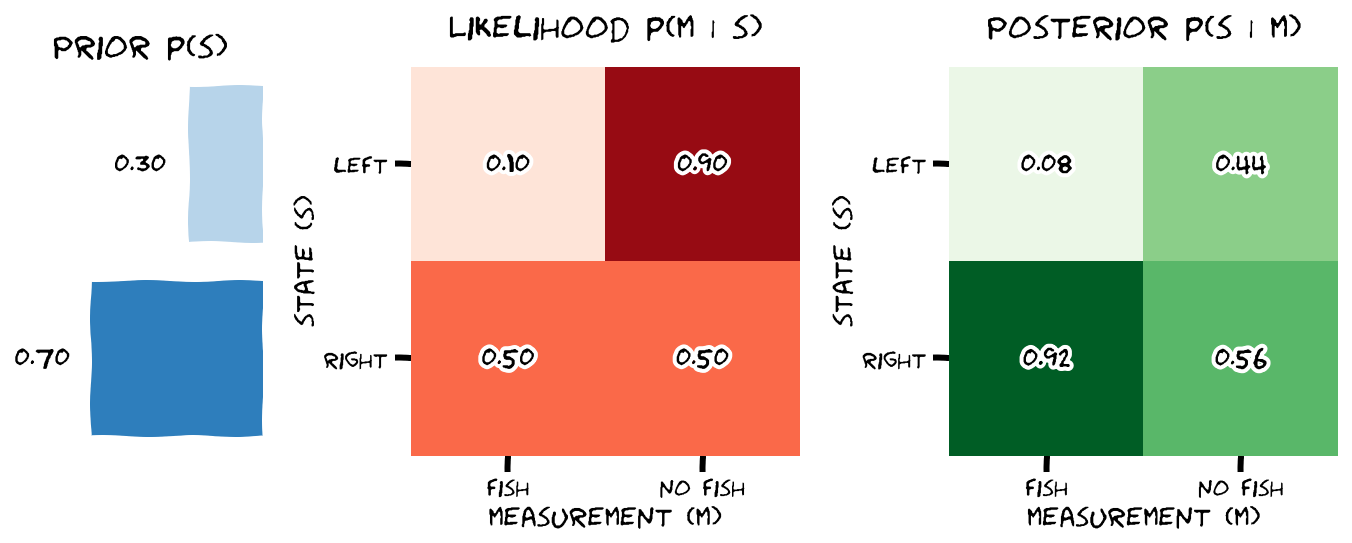

In [12]:
# to_remove solution
def compute_posterior(likelihood, prior):

  # Compute unnormalized posterior (likelihood times prior)
  posterior = likelihood * prior  # first row is s = left, second row is s = right

  # Compute normalization factors (sum over columns)
  p_m = np.sum(posterior, 0)

  # Normalize posterior (divide elements by column sum)
  posterior /= p_m

  return posterior


prior = np.array([0.3, 0.7]).reshape((2, 1)) # first row is s = left, second row is s = right

likelihood = np.array([[0.1, 0.9], [0.5, 0.5]]) # first row is s = left, second row is s = right

posterior = compute_posterior(likelihood, prior)

with plt.xkcd():
  plot_prior_likelihood_posterior(prior, likelihood, posterior)


## Interactive Demo 5: What affects the posterior?

Now that we can understand the implementation of *Bayes rule*, let's vary the parameters of the prior and likelihood to see how changing the prior and likelihood affect the posterior. 

In the demo below, you can change the prior by playing with the slider for $p( s = left)$. You can also change the likelihood by changing the probability of catching a fish given that the school is on the left and the probability of catching a fish given that the school is on the right. The fisherman you are observing is fishing on the right.
 

1.   Keeping the likelihood constant, when does the prior have the strongest influence over the posterior? Meaning, when does the posterior look most like the prior?
2.   Keeping the likelihood constant, when does the prior exert the weakest influence?  Meaning, when does the posterior look least like the prior?
3.  Set the prior probability of the state = left to 0.6 and play with the likelihood. When does the likelihood exert the most influence over the posterior?

In [13]:
# @markdown Execute this cell to enable the widget
ps_widget = widgets.FloatSlider(0.3, description='p(s = left)', min=0.0, max=1.0, step=0.01)
p_a_s1_widget = widgets.FloatSlider(0.1, description='p(fish | s = left)', min=0.0, max=1.0, step=0.01)
p_a_s0_widget = widgets.FloatSlider(0.5, description='p(fish | s = right)', min=0.0, max=1.0, step=0.01)
@widgets.interact(
    ps=ps_widget,
    p_a_s1=p_a_s1_widget,
    p_a_s0=p_a_s0_widget
)
def make_prior_likelihood_plot(ps,p_a_s1,p_a_s0):
    fig = plot_prior_likelihood(ps,p_a_s1,p_a_s0)
    plt.show(fig)
    plt.close(fig)
    return None


interactive(children=(FloatSlider(value=0.3, description='p(s = left)', max=1.0, step=0.01), FloatSlider(value…

In [14]:
# to_remove explanation

# 1).  The prior exerts a strong influence over the posterior when it is very informative: when
#.   the probability of the school being on one side or the other. If the prior that the fish are
#.   on the left side is very high (like 0.9), the posterior probability of the state being left is
#.   high regardless of the measurement.

# 2).  The prior does not exert a strong influence when it is not informative: when the probabilities
#.     of the school being on the left vs right are similar (both are 0.5 for example). In this case, 
#.     the posterior is more driven  by the collected data (the measurement) and more closely resembles 
#.     the likelihood.


#.  3) Similarly to the prior, the likelihood exerts the most influence when it is informative: when catching
#.    a fish tells you a lot of information about which state is likely. For example, if the probability of the
#.    fisherman catching a fish if he is fishing on the right side and the school is on the left is 0
#.    (p fish | s = left) = 0 and the probability of catching a fish if the school is on the right is 1, the
#.    prior does not affect the posterior at all. The measurement tells you the hidden state completely.



# Section 6: Making Bayesian fishing decisions

We will explore how to consider the expected utility of an action based on our belief (the posterior distribution) about where we think the fish are. Now we have all the components of a Bayesian decision: our prior information, the likelihood given a measurement, the posterior distribution (belief) and our utility (the gains and losses). This allows us to consider the relationship between the true value of the hidden state, $s$, and what we *expect* to get if we take action, $a$, based on our belief!

Let's use the following widget to think about the relationship between these probability distributions and utility function.

## Think! What is more important, the probabilities or the utilities?



1. Can you find a situation where the expected utility is the same for all but one combination of states and actions?
2. 

In [12]:
# @markdown Execute this cell to enable the widget
ps_widget = widgets.FloatSlider(0.3, description='p(s)', min=0.0, max=1.0, step=0.01)
p_a_s1_widget = widgets.FloatSlider(0.1, description='p(fish | s = left)', min=0.0, max=1.0, step=0.01)
p_a_s0_widget = widgets.FloatSlider(0.5, description='p(fish | s = right)', min=0.0, max=1.0, step=0.01)

@widgets.interact(
    ps=ps_widget,
    p_a_s1=p_a_s1_widget,
    p_a_s0=p_a_s0_widget,
)
def make_prior_likelihood_utility_plot(ps, p_a_s1, p_a_s0):
    fig = plot_prior_likelihood_utility(ps, p_a_s1, p_a_s0)
    plt.show(fig)
    plt.close(fig)
    return None


interactive(children=(FloatSlider(value=0.3, description='p(s)', max=1.0, step=0.01), FloatSlider(value=0.1, d…